# Exploratory Analysis on Bike Robbery at São Paulo, Brazil

*Danilo Lessa Bernardineli (danilo.lessa@gmail.com)*

## Intro

Through the help of SIC/SP (Serviço de Informação ao Cidadão), we have access to an dataset with all police reports regarding bike robbery. The temporal range is from Jan/2002 to Jul/2022 (inclusive).

This notebook is an first stab in extracting insights from that dataset.

## Setting up the essentials

In [1]:
# Dependences
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.io as pio


# Settings
pio.renderers.default = "svg" # Uncomment for plots to be visible on Github

In [14]:
# Load Data
dataset_path = '../data/dataset.csv.zip'

rename_dict = {'CIDADE': 'city'}
def convert_occurence_time(s):
    if type(s) == str:
        lst = s.split(":")
        if len(lst) == 2:
            return int(lst[0]) + int(lst[1]) / 60
        else:
            return None
    else:
        return None


df = (pd.read_csv(dataset_path)
        .assign(registry_timestamp=lambda df: pd.to_datetime(df.DATAHORA_REGISTRO_BO))
        .rename(columns=rename_dict)
        .assign(occurence_hour=lambda df: df.HORA_OCORRENCIA_BO.map(convert_occurence_time))
     )

## Analysis

In [15]:
registries_per_city = df.city.value_counts().sort_values(ascending=False)

N_head = 5
BOTTOM_CITIES_PLACERHOLDER = 'Other'
registries_per_bottom_cities = registries_per_city[N_head:]
registries_per_top_cities = registries_per_city[0:N_head]

clean_registries_per_cities = registries_per_top_cities
clean_registries_per_cities[BOTTOM_CITIES_PLACERHOLDER] = registries_per_bottom_cities.sum()

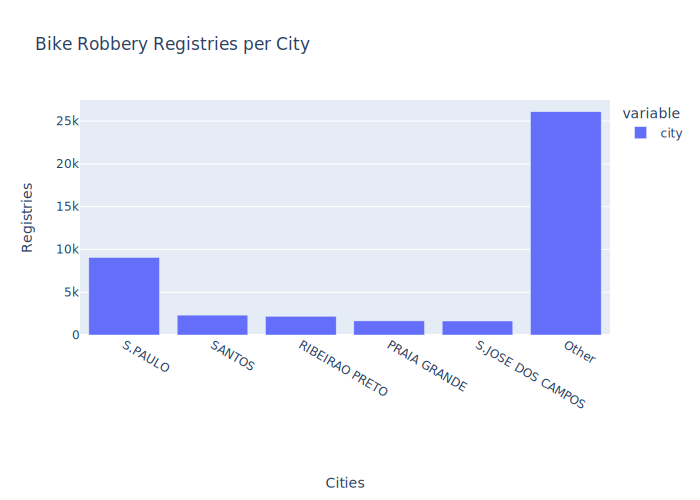

In [16]:
fig = px.bar(clean_registries_per_cities,
             title='Bike Robbery Registries per City',
             labels={'value': 'Registries',
                     'index': 'Cities'})
fig.show()

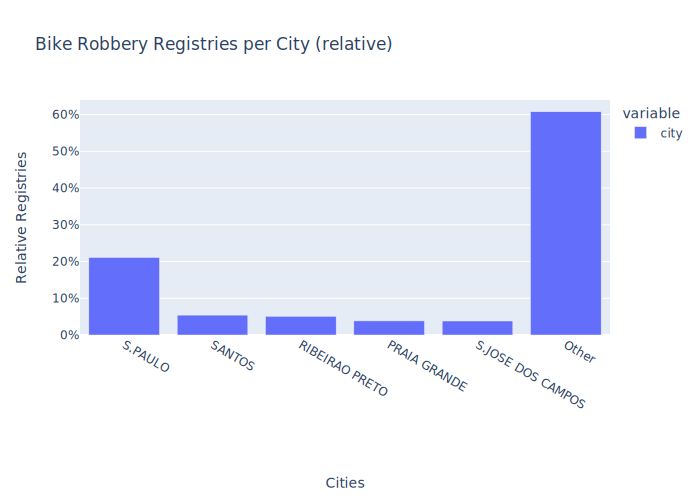

In [17]:
fig = px.bar(clean_registries_per_cities / clean_registries_per_cities.sum(),
             title='Bike Robbery Registries per City (relative)',
             labels={'value': 'Relative Registries',
                     'index': 'Cities'})

fig.layout.yaxis.tickformat = ',.0%'
fig.show()

In [18]:
top_cities = set(registries_per_top_cities.index)

    
top_cities_df = (df.assign(city=lambda df: df.city.map(lambda x: x if x in top_cities else BOTTOM_CITIES_PLACERHOLDER))
                )

registries_per_city_year = (top_cities_df.groupby(['city',
                                                  df.registry_timestamp.dt.year])
                            .count()
                            .registry_timestamp)
registries_per_city_year.name = 'count'

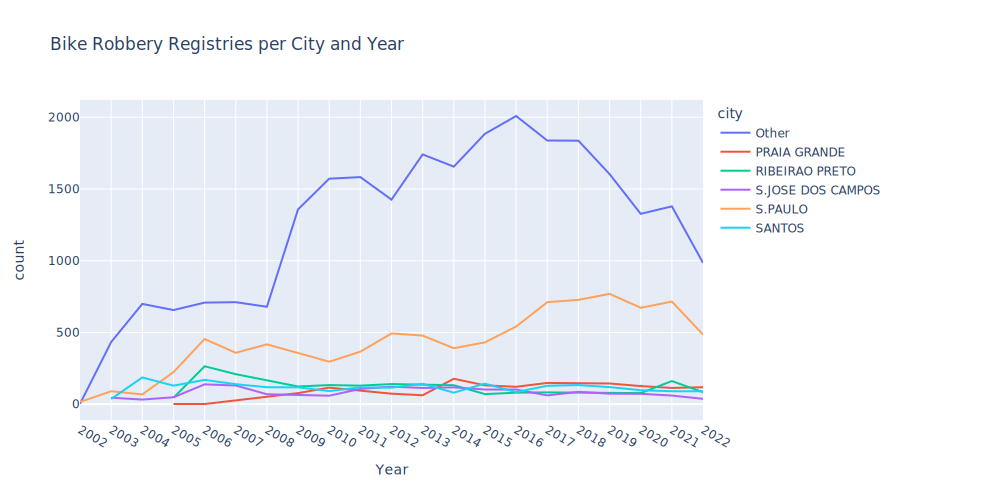

In [19]:
fig_df = registries_per_city_year.reset_index()
fig = px.line(fig_df,
              x='registry_timestamp',
              y='count',
              color='city',
              width=1000,
              title='Bike Robbery Registries per City and Year',
              labels={'value': 'Registries',
                      'registry_timestamp': 'Year'})

fig.update_layout(
    xaxis = dict(
        tickmode = 'linear',
        dtick = 1
    )
)
fig.show()

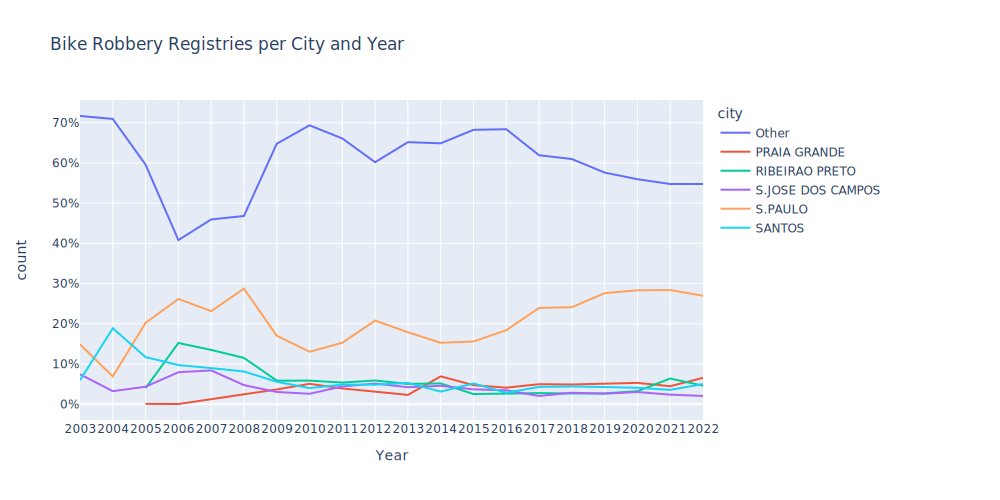

In [20]:
fig_df = (registries_per_city_year / registries_per_city_year.groupby('registry_timestamp').sum()).reset_index()
fig = px.line(fig_df.query('registry_timestamp > 2002'),
              x='registry_timestamp',
              y='count',
              color='city',
              width=1000,
              title='Bike Robbery Registries per City and Year',
              labels={'value': 'Relative Registries',
                      'registry_timestamp': 'Year'})

fig.update_layout(
    xaxis = dict(
        tickmode = 'linear',
        dtick = 1
    )
)
fig.layout.yaxis.tickformat = ',.0%'
fig.show()

#### Temporal Patterns

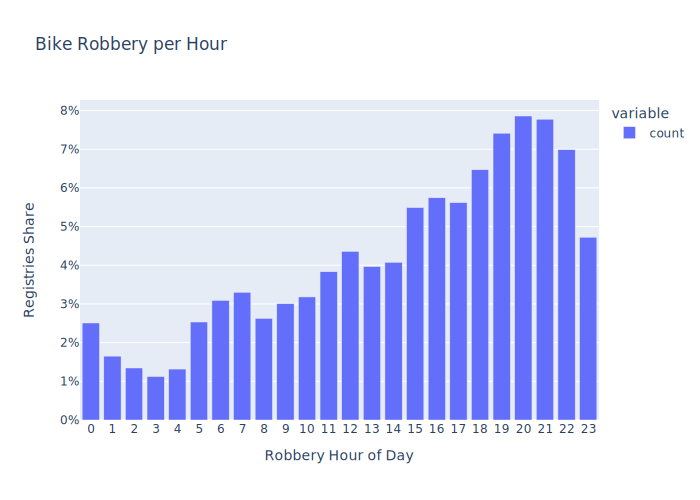

In [34]:
registries_per_hour = (top_cities_df.groupby([df.occurence_hour.map(np.floor)])
                            .count()
                            .registry_timestamp)

registries_per_hour.name = 'count'
fig = px.bar(registries_per_hour / registries_per_hour.sum(),
             title='Bike Robbery per Hour',
             labels={'value': 'Registries Share',
                     'occurence_hour': 'Robbery Hour of Day'})
fig.update_layout(
    xaxis = dict(
        tickmode = 'linear',
        dtick = 1
    )
)
fig.layout.yaxis.tickformat = ',.0%'
fig.show()

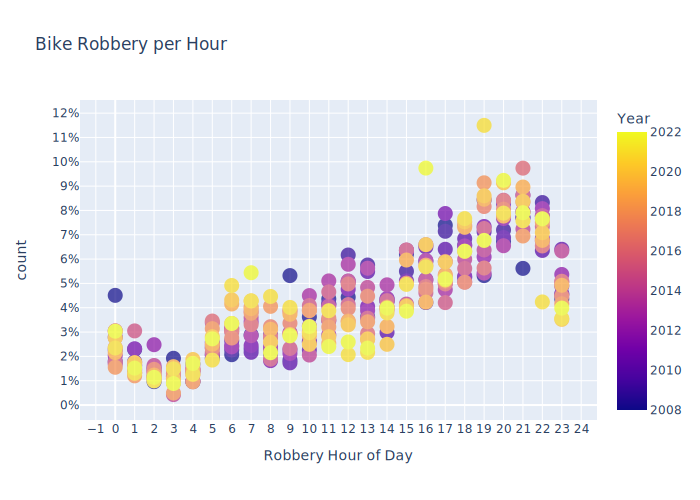

In [117]:
registries_per_year_hour = (top_cities_df.groupby([df.registry_timestamp.dt.year,
                                                   df.occurence_hour.map(np.floor)])
                            .count()
                            .registry_timestamp)

registries_per_year_hour.name = 'count'

fig_df = registries_per_year_hour / registries_per_year_hour.groupby('registry_timestamp').sum()
fig_df = fig_df.reset_index()
fig_df['registry_timestamp'] = fig_df['registry_timestamp'].astype(float)
fig_df = fig_df.query('registry_timestamp > 2007')

fig = px.scatter(fig_df,
              color='registry_timestamp',
                x='occurence_hour',
                y='count',
             title='Bike Robbery per Hour',
             labels={'registry_timestamp': 'Year',
                     'occurence_hour': 'Robbery Hour of Day'})
fig.update_layout(
    xaxis = dict(
        tickmode = 'linear',
        dtick = 1
    ),
        yaxis = dict(
        tickmode = 'linear',
        dtick = 0.01
    )
)
fig.update_traces(marker_size=15)
fig.update_traces(opacity=0.7)
fig.layout.yaxis.tickformat = ',.0%'
fig.show()

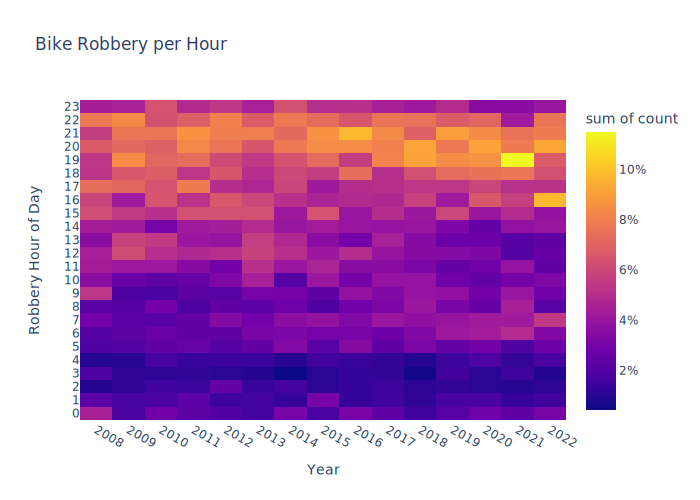

In [89]:
fig_df = registries_per_year_hour / registries_per_year_hour.groupby('registry_timestamp').sum() * 100
fig_df = fig_df.reset_index().query('registry_timestamp > 2007')

fig = px.density_heatmap(fig_df,
              x='registry_timestamp',
                y='occurence_hour',
                z='count',
                 nbinsx=25,
                 nbinsy=24,
             # y='count',
             # color='occurence_hour',
             title='Bike Robbery per Hour',
             labels={'registry_timestamp': 'Year',
                     'occurence_hour': 'Robbery Hour of Day'})
fig.update_layout(
    xaxis = dict(
        tickmode = 'linear',
        dtick = 1
    ),
        yaxis = dict(
        tickmode = 'linear',
        dtick = 1
    )
)
fig.layout.coloraxis.colorbar['ticksuffix'] = '%'
fig.show()

### Robbery on Highways

In [9]:
ind = df.LOGRADOURO.str.contains('RODOVIA')
#ind &= df.LOGRADOURO.str.contains('FERNAO')
ind &= df.DESCR_CONDUTA == 'TRANSEUNTE'
ind = ~pd.isnull(ind) & (ind == True)
df2 = df.loc[ind]

In [10]:
i = 0
print(df2.loc[ind].iloc[i].OBSERVACAO_OBJETO)
df2.loc[ind].iloc[i]


MARCA CERVELO P3 ULTEGRA -COR BRANCA


ID_DELEGACIA                                                          10101
NOME_DEPARTAMENTO                  DECAP                                   
NOME_SECCIONAL                     DEL.SEC.1º CENTRO                       
NOME_DELEGACIA                               01º D.P. SE                   
city                               GUARULHOS                               
ANO_BO                                                                 2015
NUM_BO                                                                 3020
DESCR_SOLUCAO                                ENCAMINHAMENTO DP ÁREA DO FATO
DESCR_PROVIDENCIA                                                       NaN
NOME_DEPARTAMENTO_CIRC             DEMACRO                                 
NOME_SECCIONAL_CIRC                DEL.SEC.GUARULHOS                       
NOME_DELEGACIA_CIRC                          03º D.P. GUARULHOS            
NOME_MUNICIPIO_CIRC                          GUARULHOS                     
DESCR_TIPO_B

In [11]:
df.loc[ind].iloc[40].OBSERVACAO_OBJETO

'RODAS BRANCAS E ACESSORIOS BRANCOS'

<AxesSubplot:xlabel='registry_timestamp'>

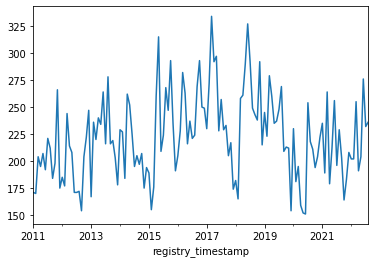

In [12]:
df.query('registry_timestamp > 2011').resample('1m', on='registry_timestamp').count().ID_DELEGACIA.plot()

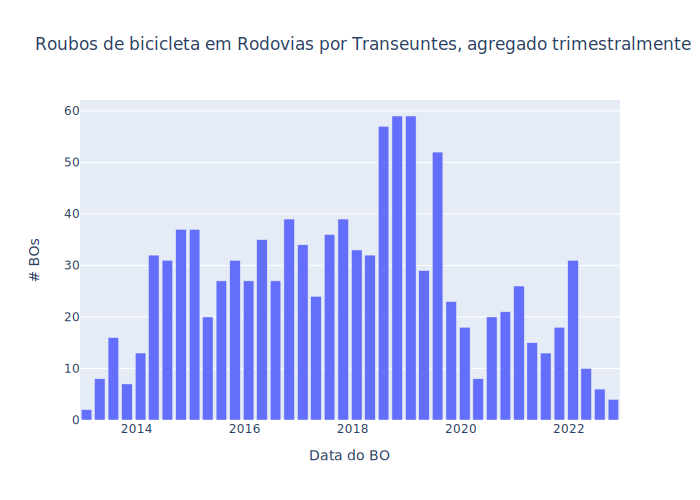

In [13]:
import plotly.express as px

df3 = df2.query('registry_timestamp >= "2013-01-01 00:00:00"').resample('3m', on='registry_timestamp').count().ID_DELEGACIA.reset_index()


px.bar(df3,
       x='registry_timestamp',
       y='ID_DELEGACIA',
       labels={'ID_DELEGACIA': '# BOs',
               'registry_timestamp': 'Data do BO'},
      title="Roubos de bicicleta em Rodovias por Transeuntes, agregado trimestralmente")

<AxesSubplot:ylabel='Frequency'>

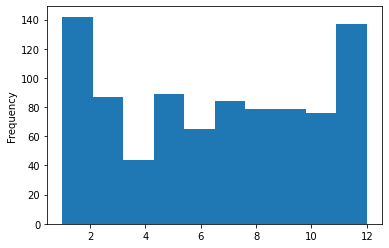

In [14]:
df2.query('registry_timestamp > "2015-01-01"').registry_timestamp.dt.month.plot(kind='hist')

<AxesSubplot:ylabel='Frequency'>

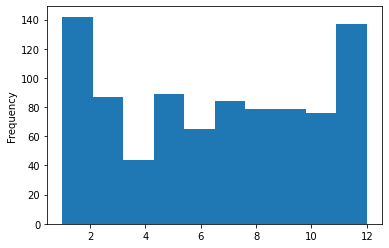

In [15]:
df2.query('registry_timestamp > "2015-01-01"').registry_timestamp.dt.month.plot(kind='hist')

In [16]:
df2.LOGRADOURO.value_counts().head(30)

RODOVIA SP 160                       101
RODOVIA DOS IMIGRANTES                68
RODOVIA SP 070                        64
RODOVIA SPA 248/055                   41
RODOVIA ANCHIETA                      28
RODOVIA SP 055                        28
RODOVIA SP 348                        23
RODOVIA AYRTON SENNA DA SILVA         22
RODOVIA SP 150                        22
RODOVIA SP 061                        22
RODOVIA PRESIDENTE DUTRA (BR 116)     21
RODOVIA SP 342                        20
RODOVIA ATILIO BALBO                  19
RODOVIA CONEGO DOMENICO RANGONI       17
RODOVIA PRES DUTRA                    15
RODOVIA AMADOR BUENO DA VEIGA         15
RODOVIA REGIS BITTENCOURT             14
RODOVIA CÔNEGO DOMÊNICO RANGONI       13
RODOVIA FERNAO DIAS                   13
RODOVIA SPA 1A 248/055                13
RODOVIA PRESIDENTE DUTRA              12
RODOVIA ABRÃO ASSED SP 333            12
RODOVIA AYRTON SENNA                  12
RODOVIA SP 147                        11
RODOVIA PADRE MA

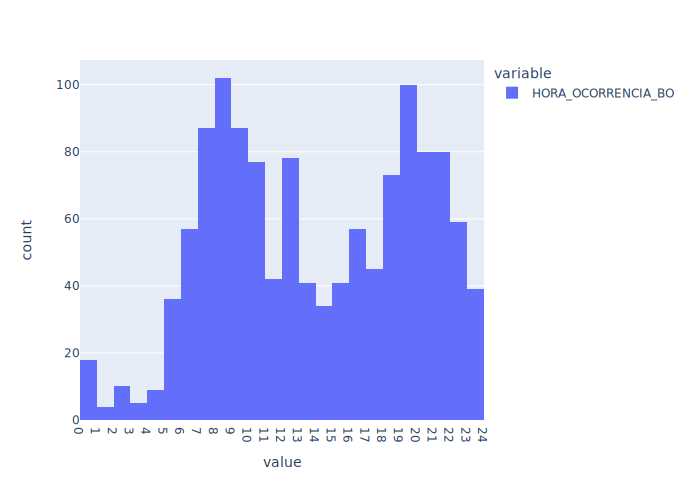

In [17]:
def f(s):
    if type(s) == str:
        lst = s.split(":")
        if len(lst) == 2:
            return int(lst[0]) + int(lst[1]) / 60
        else:
            return None
    else:
        return None

y = df2.HORA_OCORRENCIA_BO.map(lambda x: f(x))

fig = px.histogram(y, nbins=24)
fig.update_layout(
    xaxis = dict(
        tickmode = 'linear',
        tick0 = 0,
        dtick = 1
    )
)
fig.show()

In [18]:
df.NACIONALIDADE_PESSOA.value_counts().head(40)

BRASILEIRA     30337
BRASILEIRO       824
Brasil           335
BRAS.            296
BRAS             211
BOLIVIANA         45
ARGENTINA         15
PORTUGUESA        13
BRASIL            12
BOLIVIANO         11
ESPANHOLA         11
BRASIELIRA        11
ITALIANA          10
BRA               10
FRANCESA           9
BRASIL.            9
BRASILEIRA.        9
PERUANA            8
BR                 8
JAPONESA           8
B                  8
BRASIELIRO         6
BOLIVIA            6
COLOMBIA           6
COLOMBIANA         6
BRASLEIRA          6
PORTUGAL           6
BRASILIERA         5
PARAGUAIA          5
 BRASILEIRA        4
EQUATORIANA        4
BRASIILEIRA        4
HOLANDESA          4
ALEMÃ              4
COLOMBIANO         4
CHINESA            4
ALEMANHA           4
BELGA              4
PERUANO            3
URUGUAI            3
Name: NACIONALIDADE_PESSOA, dtype: int64

In [19]:
df.query('NACIONALIDADE_PESSOA == "BELGA"')

,ID_DELEGACIA,NOME_DEPARTAMENTO,NOME_SECCIONAL,NOME_DELEGACIA,city,ANO_BO,NUM_BO,DESCR_SOLUCAO,DESCR_PROVIDENCIA,NOME_DEPARTAMENTO_CIRC,...,NACIONALIDADE_PESSOA,NATURALIDADE_PESSOA,CONT_OBJETO,DESCR_MODO_OBJETO,DESCR_TIPO_OBJETO,DESCR_SUBTIPO_OBJETO,DESCR_UNIDADE,QUANTIDADE_OBJETO,OBSERVACAO_OBJETO,registry_timestamp
13788,30110,DEMACRO,DEL.SEC.S.BERNARDO DO CAMPO,02º D.P. S.BERNARDO DO CAMPO,DIADEMA,2017,988,ENCAMINHAMENTO DP ÁREA DO FATO,NaN,DEMACRO,...,BELGA,NaN,3,SUBTRAÍDO,Esporte e lazer,Bicicleta ...,Unidade,NaN,MODELO GRANFONDO,2017-03-12 11:12:00
18072,70304,DEINTER 2 - CAMPINAS,DEL.SEC.1º CAMPINAS,04º D.P. CAMPINAS,CAMPINAS,2007,607,APRECIAÇÃO DO DELEGADO TITULAR,NaN,DEINTER 2 - CAMPINAS,...,BELGA,BELGICA,1,SUBTRAÍDO,Esporte e lazer,Bicicleta ...,Unidade,1.0,VERMELHA - PNEU TRAZEIRO PRETO E VERMELHO E DI...,2007-01-16 20:36:00
22866,70402,DEINTER 2 - CAMPINAS,DEL.SEC.JUNDIAI,DEL.POL.CAMPO LIMPO PAULISTA,CAMPO LIMPO PAULISTA,2016,3400,BO PARA INVESTIGAÇÃO,NaN,DEINTER 2 - CAMPINAS,...,BELGA,NaN,1,SUBTRAÍDO,Esporte e lazer,Bicicleta ...,Unidade,1.0,COR PRETA FOSCA- ARO 29,2016-09-19 11:35:00
39360,70402,DEINTER 2 - CAMPINAS,DEL.SEC.JUNDIAI,DEL.POL.CAMPO LIMPO PAULISTA,CAMPO LIMPO PAULISTA,2016,3400,BO PARA INVESTIGAÇÃO,NaN,DEINTER 2 - CAMPINAS,...,BELGA,NaN,2,SUBTRAÍDO,Esporte e lazer,Bicicleta ...,Unidade,1.0,COR PRETA COM DETALHES VERDE E BRANCO,2016-09-19 11:35:00
